# Introduction to Integer Programming

```{admonition} Learning outcomes
After reading this note, you will be able to:
- Model a discrete optimization problem using the language of integer linear programming
- Describe the branch-and-bound algorithm
```


## Problem statement
*Integer Linear Programming* (ILP) is not new to you. In fact, the bin packing problem from last week was modeled using the language of ILP as:
```{math}
\min_{\boldsymbol{x}, \boldsymbol{y}} \quad & \sum_{i=1}^{n}{y_i}\\
\text{subject to} \quad 
& \sum_{j=1}^{n}{w_j x_{ij}} \leq c y_i, \quad &\forall i\in[n],\\
& \sum_{i=1}^{n}{ x_{ij}} = 1, \quad&\forall j\in[n],\\
& y_i\in\{0,1\}, \quad &\forall i\in[n],\\
& x_{ij}\in\{0,1\}, \quad &\forall i\in[n],j\in[n].
```
An ILP consists of integer decision variables, an objective function that is linear in those variables, and constraints that are linear in those variables as well. If any of the decision variables is required to be continuous, the optimization problem becomes a *Mixed*-Integer Linear Program (MILP). The word "program" or "programming" here do not refer to writing code but rather to optimization; think of it as mixed-integer linear optimization if you so prefer.

A MILP with $n$ integer variables $\boldsymbol{x}$, $p$ continuous variables $\boldsymbol{y}$, and $m$ linear inequality constraints (we can also use equality constraints), writes:
```{math}
\min_{\boldsymbol{x}, \boldsymbol{y}} \quad & \boldsymbol{c}^\intercal\boldsymbol{x} +\boldsymbol{h}^\intercal\boldsymbol{y} =\sum_{i=1}^{n}{c_i x_i}+\sum_{j=1}^{p}{h_j y_j}\\
\text{subject to} \quad 
& \sum_{i=1}^{n}{a_{k,i} x_{i}} + \sum_{j=1}^{p}{g_{k,j} y_{j}}  \leq b_k, \quad &\forall k\in[m],\\
& x_{i}\in\mathbb{N}, \quad &\forall i\in[n],\\
& y_{j}\in\mathbb{R}_{\geq 0}, \quad &\forall j\in[p].
```
Note that $\mathbb{N}=\{0,1,2,\dots\}$ is the set of natural integers. If we organize the constraint coefficients $a_{k,i}$ into a matrix $\boldsymbol{A}$ with $m$ rows (one per constraint) and $n$ columns (one per variable), then the $m$ values for $\sum_{i=1}^{n}{a_{k,i} x_{i}}$ can be written neatly as $\boldsymbol{A}\boldsymbol{x}$, where $\boldsymbol{x}$ is a column vector of dimension $n$. The same can be done with the continuous variables. Organizing the right-hand side constraint coefficents $b_k$ into a column vector $\boldsymbol{b}$, the linear constraints can be re-expressed compactly as:
```{math}
\boldsymbol{A}\boldsymbol{x} + \boldsymbol{G}\boldsymbol{y} \leq \boldsymbol{b}
```
These linear inequality can constrains typically include upper bounds on the variables, i.e., constraints of the form $x_i\leq u_i$. 

## Lower and upper bounds to a MILP's optimal value
### The LP Relaxation lower bounds
We have also already looked at the concept of a relaxation. The Linear Programming (LP) relaxation of a MILP simply removes the requirement of integrality for the relevant decision variables. 
```{math}
\min_{\boldsymbol{x}, \boldsymbol{y}} \quad & \boldsymbol{c}^\intercal\boldsymbol{x} +\boldsymbol{h}^\intercal\boldsymbol{y}\\
\text{subject to} \quad 
&\boldsymbol{A}\boldsymbol{x} + \boldsymbol{G}\boldsymbol{y} \leq \boldsymbol{b},\\
& x_{i}\in\mathbb{R}_{\geq 0}, \quad &\forall i\in[n],\\
& y_{j}\in\mathbb{R}_{\geq 0}, \quad &\forall j\in[p].
```
Let $\Omega$ be the non-empty set of feasible solutions of a MILP and $\Omega'$ that of its relaxation's. Let $z^{\star}(\Omega)$ be the *optimal value* of the MILP and $z^{\star}(\Omega')$ that of the LP relaxation. The following inequality holds true:
```{math}
z^{\star}(\Omega')\leq z^{\star}(\Omega).
```
In words, the relaxation's optimal value is an *optimistic* lower bound on the optimal value of the MILP. 

### A feasible solution upper bounds
Now consider an integer-feasible solution $(\boldsymbol{\hat{x}},\boldsymbol{\hat{y}})\in\Omega$ to the MILP. The best objective function value it can it achieve is the optimal value of the MILP, $z^{\star}(\Omega)$, so it upper bounds it:
```{math}
z^{\star}(\Omega')\leq z^{\star}(\Omega)\leq \boldsymbol{c}^\intercal\boldsymbol{\hat{x}} +\boldsymbol{h}^\intercal\boldsymbol{\hat{y}}.
```

## Branch and bound: an illustrative example
Let's try to solve a ILP using only LP relaxations and divide-and-conquer!

In [1]:
from sympy import * #Symbol, symbols, sin, cos, Polygon, solve, lambdify, Rational, pi, N
from sympy.plotting import plot
from spb import *
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams['figure.dpi'] = 200

sns.set_theme()
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 3.5})
sns.set_style("white")
sns.set_style("ticks")
plt.rcParams.update({
    "text.usetex": True,
    # "font.family": "courier",
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

## An easy integer linear program

First, we'll look at the integer version of the linear program from the second constrained optimization lecture. If we relax the integrality requirement on the variables and solve the LP relaxation, we obtain an optimal LP solution $(1,0)$. Interestingly, this solution happens to be fully integer, despite the LP not requiring it! Because the LP relaxation of an ILP gives an optimistic lower bound on the latter's optimal value, the solution $(1,0)$ must also be optimal in the ILP. This can be shown by contradiction: if there was a strictly better integer solution than $(1,0)$, it would mean that $(1,0)$ is not optimal for the LP relaxation, a contradiction.

/Users/lyes/Dropbox/UofT/Teaching/MIE1666_F24/1666env/lib/python3.10/site-packages/spb/backends/matplotlib/renderers/contour.py:20: UserWarning: linewidths is ignored by contourf


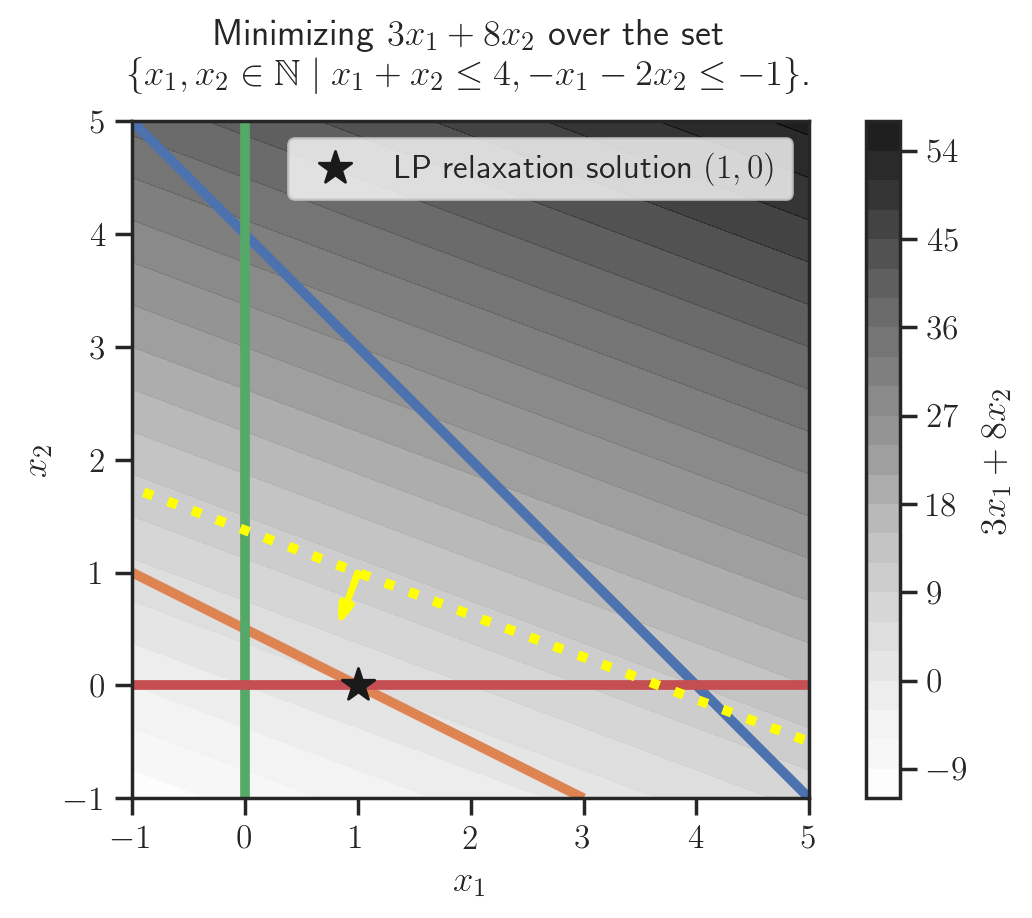

In [2]:
fig, ax = plt.subplots()
# ax.set_axis_off()

x1, x2 = symbols('x1 x2')
p1 = plot_implicit(
    Eq(x1 + x2 - 4, 0),
    Eq(-x1 + -2*x2 + 1, 0),
    Eq(x1, 0),
    Eq(x2, 0),
    (x1, -1, 5), (x2, -1, 5),
    {"linestyles": "-"}, aspect="equal",
    show=False, grid=False, show_in_legend=False, fig=fig, ax=ax)

objective_function = 3*x1+8*x2
objective_contour = plot_contour(objective_function,  (x1, -1, 5), (x2, -1, 5), 
                                 {"levels": 25, "cmap": "Greys", "alpha":0.9, "linestyles": "-", "linewidths": 1.5}, 
                                 is_filled=True, show=False, legend=False, fig=fig, ax=ax)
objective_line = plot((-3.0/8)*x1 + 11.0/8, rendering_kw={'color':'yellow','linestyle':':'}, show_in_legend=False, show=False, legend=False, fig=fig, ax=ax)

ax.set_title(
    "Minimizing $%s$ over the set\n $\{x_1, x_2\in\mathbb{N}\;|\;x_1 + x_2 \leq 4, -x_1 -2x_2 \leq -1\}$."
    % latex(objective_function),y=1.03)

obj_vec = graphics(arrow_2d((1, 1), (-.15,-.4), rendering_kw={'color':'yellow','linewidth':2}, show_in_legend=False), show=False, fig=fig, ax=ax)

from sympy.solvers.simplex import lpmax
minimizer = (lpmax(-objective_function, [x1 + x2 - 4 <= 0, -x1 + -2*x2 + 1 <= 0, x1 >= 0, x2 >= 0]))
# maximizer = (lpmax(objective_function, [x1 + x2 - 4 <= 0, -x1 + -2*x2 + 1 <= 0, x1 >= 0, x2 >= 0]))
# plt.scatter(maximizer[1][x1], maximizer[1][x2], marker='*', s=150, color='yellow', zorder=100, label='maximizer $(%d,%d)$' % (maximizer[1][x1], maximizer[1][x2]))
plt.scatter(minimizer[1][x1], minimizer[1][x2], marker='*', s=150, color='k', zorder=100, label='LP relaxation solution $(%d,%d)$' % (minimizer[1][x1], minimizer[1][x2]))


p1.append(objective_contour[0])
p1.append(objective_line[0])
p1.append(obj_vec[0])
p1.show()

## A more complicated situation

The next ILP has the same feasible region as the previous but with a slightly different objective function. We begin by solving the LP relaxation of this ILP, as before. The LP solution is $(0,0.5)$. Since $x_2$ is fractional and not integer in this solution, it is infeasible for the ILP. This solution nonetheless provides a lower *bound* on the optimal value of the ILP, which is equal to $4$. An optimal ILP solution must have value $4$ or larger.

We are now prepared to *branch* on one of the two variables. Since $x_1$ is already integer in the LP solution, we do not branch on it. $x_2$ is the only branching variable candidate. To branch, we create two new subproblems. These subproblems consist of the original ILP with the addition of a single constraint on the branching variable. In this case, one subproblem will have the added constraint $x_2\geq 1$ and the other will have $x_2\leq 0 \Longleftrightarrow x_2=0$. These new constraints make sense because $x_2$ must be integer and thus cannot take on any value in $(0,1)$, the two integers around $0.5$, the value of $x_2$ in the LP solution.

/Users/lyes/Dropbox/UofT/Teaching/MIE1666_F24/1666env/lib/python3.10/site-packages/spb/backends/matplotlib/renderers/contour.py:20: UserWarning: linewidths is ignored by contourf


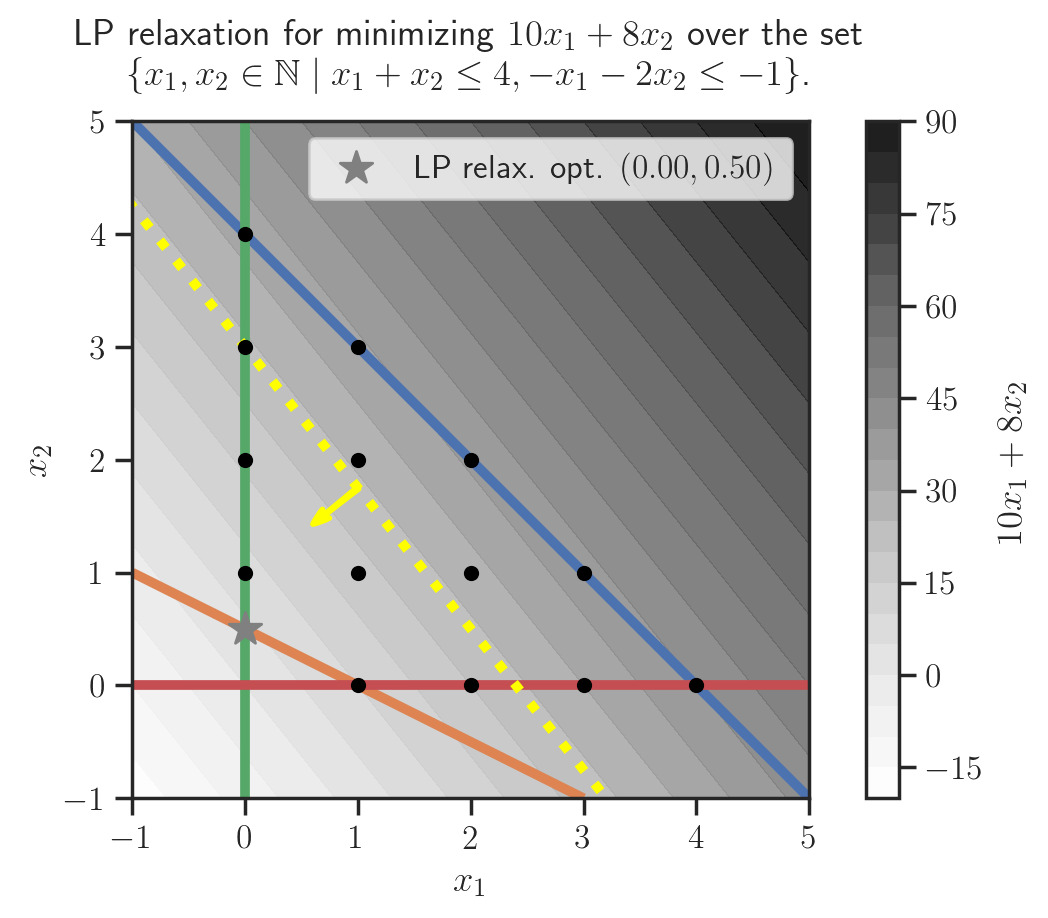

In [3]:
fig, ax = plt.subplots()
# ax.set_axis_off()

x1, x2 = symbols('x1 x2')
p1 = plot_implicit(
    Eq(x1 + x2 - 4, 0),
    Eq(-x1 + -2*x2 + 1, 0),
    Eq(x1, 0),
    Eq(x2, 0),
    (x1, -1, 5), (x2, -1, 5),
    {"linestyles": "-"}, aspect="equal",
    show=False, grid=False, show_in_legend=False, fig=fig, ax=ax)

objective_function = 10*x1+8*x2
objective_contour = plot_contour(objective_function,  (x1, -1, 5), (x2, -1, 5), 
                                 {"levels": 25, "cmap": "Greys", "alpha":0.9, "linestyles": "-", "linewidths": 1.5}, 
                                 is_filled=True, show=False, legend=False, fig=fig, ax=ax)
objective_line = plot((-10.0/8)*x1 + 3, rendering_kw={'color':'yellow','linestyle':':'}, show_in_legend=False, show=False, legend=False, fig=fig, ax=ax)

ax.set_title(
    "LP relaxation for minimizing $%s$ over the set\n $\{x_1, x_2\in\mathbb{N}\;|\;x_1 + x_2 \leq 4, -x_1  -2x_2 \leq -1\}$."
    % latex(objective_function),y=1.03)

obj_vec = graphics(arrow_2d((1, 14.0/8), (-.4,-.32), rendering_kw={'color':'yellow','linewidth':2}, show_in_legend=False), show=False, fig=fig, ax=ax)

from sympy.solvers.simplex import lpmax
minimizer = (lpmax(-objective_function, [x1 + x2 - 4 <= 0, -x1 + -2*x2 + 1 <= 0, x1 >= 0, x2 >= 0]))
# maximizer = (lpmax(objective_function, [x1 + x2 - 4 <= 0, -x1 + -2*x2 + 1 <= 0, x1 >= 0, x2 >= 0]))
# plt.scatter(1, 0, marker='*', s=150, color='yellow', zorder=100, label='IP optimum $(%d,%d)$' % (maximizer[1][x1], maximizer[1][x2]))
plt.scatter(minimizer[1][x1], minimizer[1][x2], marker='*', s=150, color='grey', zorder=100, label='LP relax. opt. $(%.2f,%.2f)$' % (minimizer[1][x1], minimizer[1][x2]))

integer_points = [(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(2,0),(2,1),(2,2),(3,0),(3,1),(4,0)]
for point in integer_points:
    plt.scatter(point[0], point[1], marker='o', s=20, color='black', zorder=90)

p1.append(objective_contour[0])
p1.append(objective_line[0])
p1.append(obj_vec[0])
p1.show()

## Branching: the first subproblem

Notice how in the next figure, we've moved the red constraint up to signify that in this subproblem $x_2\geq 1$, a stronger condition than $x_2\geq 0$. As we did in the initial step, we solve the LP relaxation of this subproblem, yielding a solution $(0,1)$. Since this solution is integer, we need not branch any further in this subproblem: this solution's objective value of $8$ is the best that can be achieved when $x_2\geq 1$. We record this integer solution as the *incumbent*, i.e., the best integer solution encountered thus far. We can move on to the other subproblem.

/Users/lyes/Dropbox/UofT/Teaching/MIE1666_F24/1666env/lib/python3.10/site-packages/spb/backends/matplotlib/renderers/contour.py:20: UserWarning: linewidths is ignored by contourf


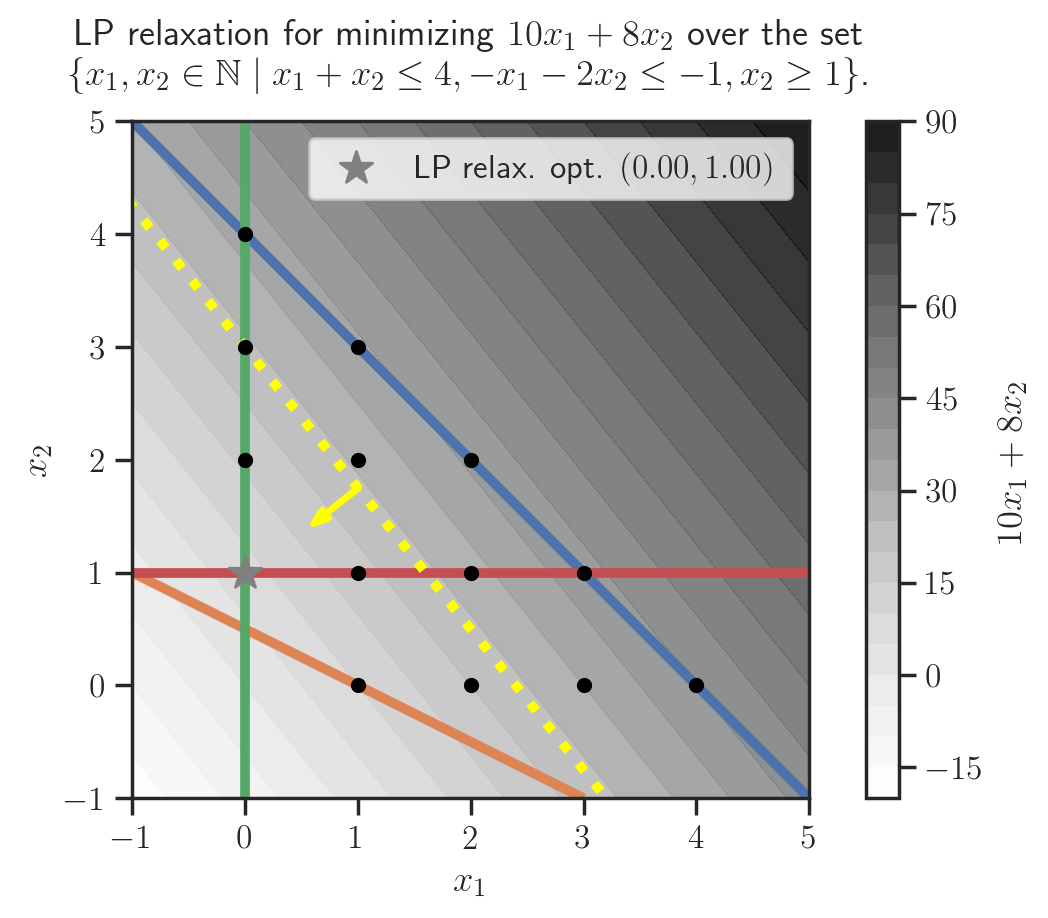

In [4]:
fig, ax = plt.subplots()
# ax.set_axis_off()

x1, x2 = symbols('x1 x2')
p1 = plot_implicit(
    Eq(x1 + x2 - 4, 0),
    Eq(-x1 + -2*x2 + 1, 0),
    Eq(x1, 0),
    Eq(x2, 1),
    (x1, -1, 5), (x2, -1, 5),
    {"linestyles": "-"}, aspect="equal",
    show=False, grid=False, show_in_legend=False, fig=fig, ax=ax)

objective_function = 10*x1+8*x2
objective_contour = plot_contour(objective_function,  (x1, -1, 5), (x2, -1, 5), 
                                 {"levels": 25, "cmap": "Greys", "alpha":0.9, "linestyles": "-", "linewidths": 1.5}, 
                                 is_filled=True, show=False, legend=False, fig=fig, ax=ax)
objective_line = plot((-10.0/8)*x1 + 3, rendering_kw={'color':'yellow','linestyle':':'}, show_in_legend=False, show=False, legend=False, fig=fig, ax=ax)

ax.set_title(
    "LP relaxation for minimizing $%s$ over the set\n $\{x_1, x_2\in\mathbb{N}\;|\;x_1 + x_2 \leq 4, -x_1  -2x_2 \leq -1, x_2 \geq 1\}$."
    % latex(objective_function),y=1.03)

obj_vec = graphics(arrow_2d((1, 14.0/8), (-.4,-.32), rendering_kw={'color':'yellow','linewidth':2}, show_in_legend=False), show=False, fig=fig, ax=ax)

from sympy.solvers.simplex import lpmax
minimizer = (lpmax(-objective_function, [x1 + x2 - 4 <= 0, -x1 + -2*x2 + 1 <= 0, x1 >= 0, x2 >= 1]))
# maximizer = (lpmax(objective_function, [x1 + x2 - 4 <= 0, -x1 + -2*x2 + 1 <= 0, x1 >= 0, x2 >= 0]))
# plt.scatter(1, 0, marker='*', s=150, color='yellow', zorder=100, label='IP optimum $(%d,%d)$' % (maximizer[1][x1], maximizer[1][x2]))
plt.scatter(minimizer[1][x1], minimizer[1][x2], marker='*', s=150, color='grey', zorder=100, label='LP relax. opt. $(%.2f,%.2f)$' % (minimizer[1][x1], minimizer[1][x2]))

integer_points = [(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(2,0),(2,1),(2,2),(3,0),(3,1),(4,0)]
for point in integer_points:
    plt.scatter(point[0], point[1], marker='o', s=20, color='black', zorder=90)

p1.append(objective_contour[0])
p1.append(objective_line[0])
p1.append(obj_vec[0])
p1.show()

## Branching: the second subproblem

Now we add the constraint $x_2\leq 0$, which combined with the original constraint $x_2\geq 0$ implies that in this subproblem any solution must have $x_2=0$. The feasible region is simply the red line segment from $(1,0)$ to $(4,0)$. The LP relaxation solution must be at the boundaries of this line segment, in particular on the left end of it as we are minimizing. This gives the solution $(1,0)$ with objective value $10$. Since $10>8$, this new integer solution is not a new incumbent. This subproblem's LP relaxation solution also happened to be integer, meaning we do not need to branch further. Since we have more subproblems to attack, we have solved the ILP to optimality! The optimal solution is $(0,1)$.

Of course, in most practical ILPs, we will need to divide up these subproblems further, but the same bounding-by-LP-relaxation then branching on any fractional variable in the subproblem's LP relaxation apply. Rules for pruning subproblems have been described in the lecture slides on OneDrive.

/Users/lyes/Dropbox/UofT/Teaching/MIE1666_F24/1666env/lib/python3.10/site-packages/spb/backends/matplotlib/renderers/contour.py:20: UserWarning: linewidths is ignored by contourf


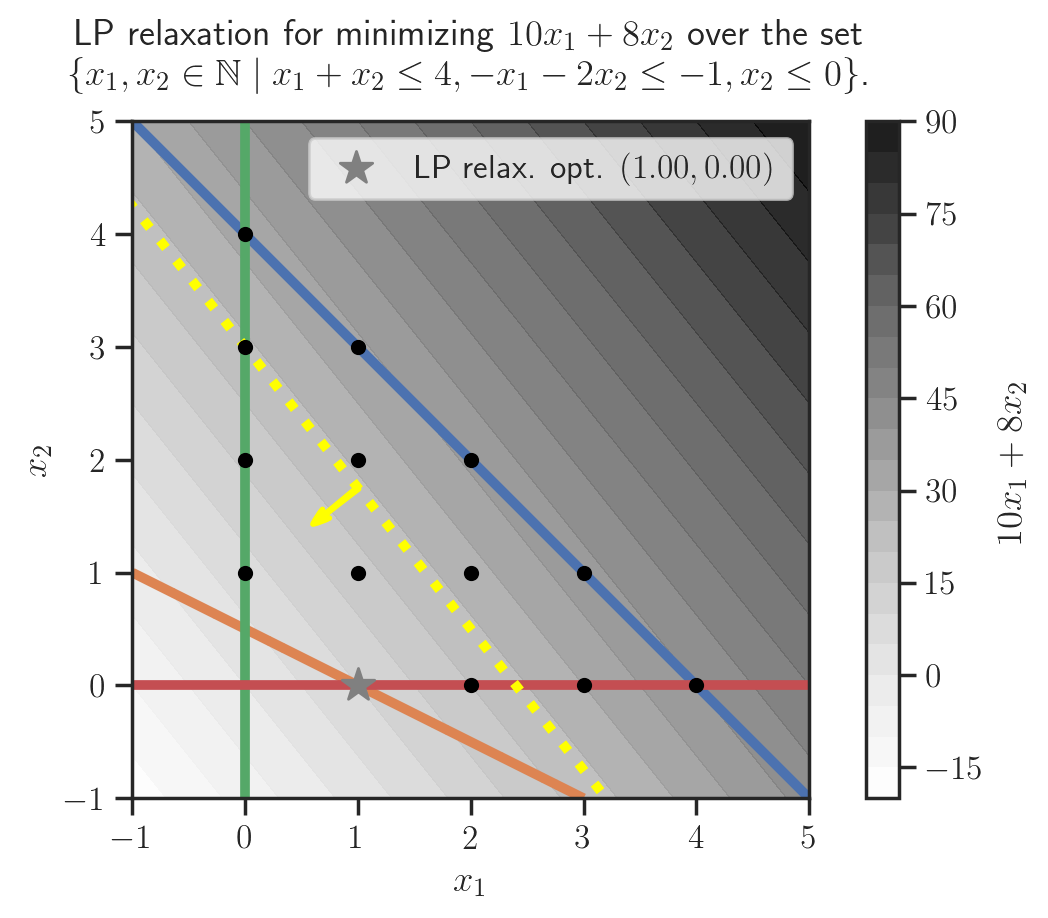

In [5]:
fig, ax = plt.subplots()
# ax.set_axis_off()

x1, x2 = symbols('x1 x2')
p1 = plot_implicit(
    Eq(x1 + x2 - 4, 0),
    Eq(-x1 + -2*x2 + 1, 0),
    Eq(x1, 0),
    Eq(x2, 0),
    (x1, -1, 5), (x2, -1, 5),
    {"linestyles": "-"}, aspect="equal",
    show=False, grid=False, show_in_legend=False, fig=fig, ax=ax)

objective_function = 10*x1+8*x2
objective_contour = plot_contour(objective_function,  (x1, -1, 5), (x2, -1, 5), 
                                 {"levels": 25, "cmap": "Greys", "alpha":0.9, "linestyles": "-", "linewidths": 1.5}, 
                                 is_filled=True, show=False, legend=False, fig=fig, ax=ax)
objective_line = plot((-10.0/8)*x1 + 3, rendering_kw={'color':'yellow','linestyle':':'}, show_in_legend=False, show=False, legend=False, fig=fig, ax=ax)

ax.set_title(
    "LP relaxation for minimizing $%s$ over the set\n $\{x_1, x_2\in\mathbb{N}\;|\;x_1 + x_2 \leq 4, -x_1  -2x_2 \leq -1, x_2 \leq 0\}$."
    % latex(objective_function),y=1.03)

obj_vec = graphics(arrow_2d((1, 14.0/8), (-.4,-.32), rendering_kw={'color':'yellow','linewidth':2}, show_in_legend=False), show=False, fig=fig, ax=ax)

from sympy.solvers.simplex import lpmax
minimizer = (lpmax(-objective_function, [x1 + x2 - 4 <= 0, -x1 + -2*x2 + 1 <= 0, x1 >= 0, x2 <= 0]))
# maximizer = (lpmax(objective_function, [x1 + x2 - 4 <= 0, -x1 + -2*x2 + 1 <= 0, x1 >= 0, x2 >= 0]))
# plt.scatter(1, 0, marker='*', s=150, color='yellow', zorder=100, label='IP optimum $(%d,%d)$' % (maximizer[1][x1], maximizer[1][x2]))
plt.scatter(minimizer[1][x1], minimizer[1][x2], marker='*', s=150, color='grey', zorder=100, label='LP relax. opt. $(%.2f,%.2f)$' % (minimizer[1][x1], minimizer[1][x2]))

integer_points = [(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(2,0),(2,1),(2,2),(3,0),(3,1),(4,0)]
for point in integer_points:
    plt.scatter(point[0], point[1], marker='o', s=20, color='black', zorder=90)

p1.append(objective_contour[0])
p1.append(objective_line[0])
p1.append(obj_vec[0])
p1.show()

/Users/lyes/Dropbox/UofT/Teaching/MIE1666_F24/1666env/lib/python3.10/site-packages/spb/backends/matplotlib/renderers/contour.py:20: UserWarning: linewidths is ignored by contourf


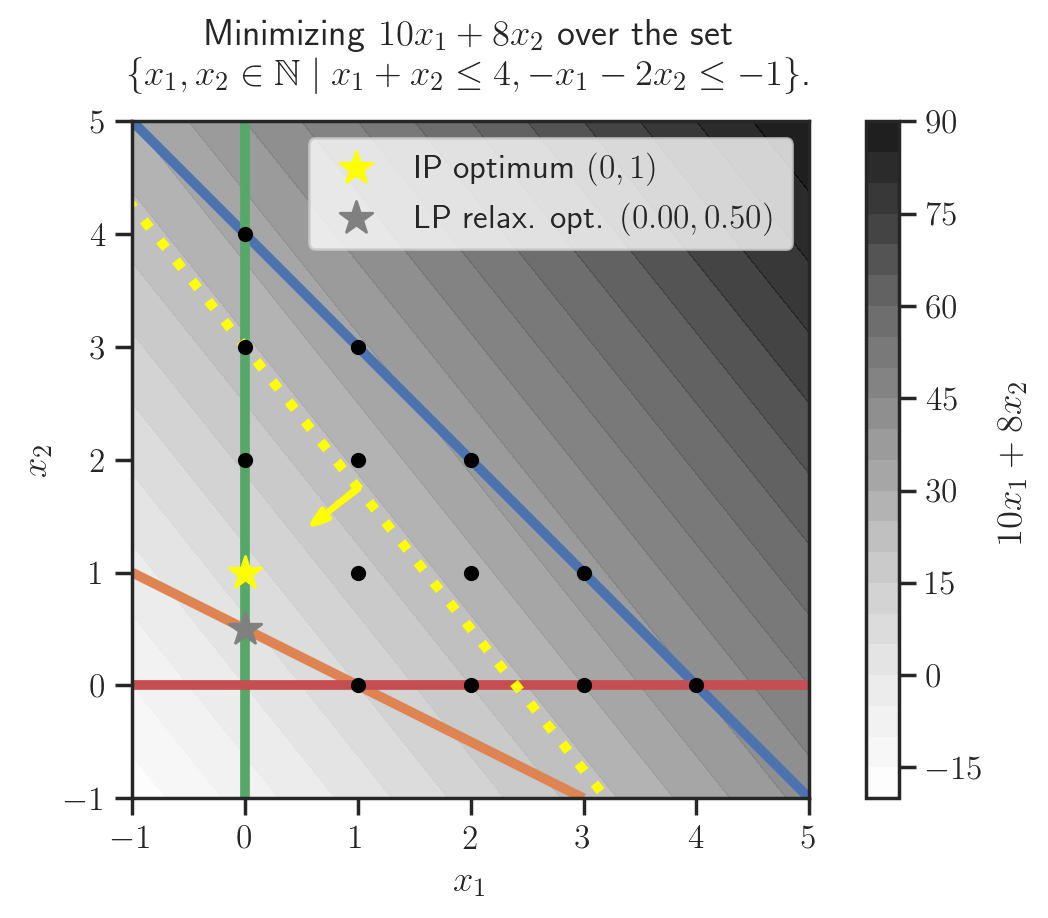

In [9]:
fig, ax = plt.subplots()
# ax.set_axis_off()

x1, x2 = symbols('x1 x2')
p1 = plot_implicit(
    Eq(x1 + x2 - 4, 0),
    Eq(-x1 + -2*x2 + 1, 0),
    Eq(x1, 0),
    Eq(x2, 0),
    (x1, -1, 5), (x2, -1, 5),
    {"linestyles": "-"}, aspect="equal",
    show=False, grid=False, show_in_legend=False, fig=fig, ax=ax)

objective_function = 10*x1+8*x2
objective_contour = plot_contour(objective_function,  (x1, -1, 5), (x2, -1, 5), 
                                 {"levels": 25, "cmap": "Greys", "alpha":0.9, "linestyles": "-", "linewidths": 1.5}, 
                                 is_filled=True, show=False, legend=False, fig=fig, ax=ax)
objective_line = plot((-10.0/8)*x1 + 3, rendering_kw={'color':'yellow','linestyle':':'}, show_in_legend=False, show=False, legend=False, fig=fig, ax=ax)

ax.set_title(
    "Minimizing $%s$ over the set\n $\{x_1, x_2\in\mathbb{N}\;|\;x_1 + x_2 \leq 4, -x_1  -2x_2 \leq -1\}$."
    % latex(objective_function),y=1.03)

obj_vec = graphics(arrow_2d((1, 14.0/8), (-.4,-.32), rendering_kw={'color':'yellow','linewidth':2}, show_in_legend=False), show=False, fig=fig, ax=ax)

from sympy.solvers.simplex import lpmax
minimizer = (lpmax(-objective_function, [x1 + x2 - 4 <= 0, -x1 + -2*x2 + 1 <= 0, x1 >= 0, x2 >= 0]))
# maximizer = (lpmax(objective_function, [x1 + x2 - 4 <= 0, -x1 + -2*x2 + 1 <= 0, x1 >= 0, x2 >= 0]))
plt.scatter(0, 1, marker='*', s=150, color='yellow', zorder=100, label='IP optimum $(%d,%d)$' % (0, 1))
plt.scatter(minimizer[1][x1], minimizer[1][x2], marker='*', s=150, color='grey', zorder=100, label='LP relax. opt. $(%.2f,%.2f)$' % (minimizer[1][x1], minimizer[1][x2]))

integer_points = [(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(2,0),(2,1),(2,2),(3,0),(3,1),(4,0)]
for point in integer_points:
    plt.scatter(point[0], point[1], marker='o', s=20, color='black', zorder=90)

p1.append(objective_contour[0])
p1.append(objective_line[0])
p1.append(obj_vec[0])
p1.show()